<a href="https://colab.research.google.com/github/jacobrast/11785-hw4p1/blob/main/HW4P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [185]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [186]:
config = {
    'batch_size': 32,
    'lr': 0.1,
    'epochs': 15,
    #'sgd_momentum' : 0.9,
    'sgd_weight_decay' : 1e-5,
    'num_epochs': 10,
    'emb_dim' : 400,
    'hidden_size' : 1150,
    'dropout' : 0.0,
    "small_data" : False
}

In [187]:
def log_softmax(x, axis):
    ret = x - np.max(x, axis=axis, keepdims=True)
    lsm = np.log(np.sum(np.exp(ret), axis=axis, keepdims=True))
    return ret - lsm


def array_to_str(arr, vocab):
    return " ".join(vocab[a] for a in arr)


def test_prediction(out, targ):
    out = log_softmax(out, 1)
    nlls = out[np.arange(out.shape[0]), targ]
    nll = -np.mean(nlls)
    return nll


def test_generation(inp, pred, vocab):
    outputs = u""
    for i in range(inp.shape[0]):
        w1 = array_to_str(inp[i], vocab)
        w2 = array_to_str(pred[i], vocab)
        outputs += u"Input | Output #{}: {} | {}\n".format(i, w1, w2)
    return outputs

In [188]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [189]:
!tar -xf "/content/drive/MyDrive/Colab Notebooks/handout_hw4.tar"

In [190]:
# load all that we need

dataset = np.load('handout/dataset/wiki.train.npy', allow_pickle=True)
devset = np.load('handout/dataset/wiki.valid.npy', allow_pickle=True)
fixtures_pred = np.load('handout/fixtures/prediction.npz')  # dev
fixtures_gen = np.load('handout/fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('handout/fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('handout/fixtures/generation_test.npy')  # test
vocab = np.load('handout/dataset/vocab.npy')

In [191]:
print(array_to_str(fixtures_gen[1], vocab))
print(array_to_str(fixtures_gen_test[0], vocab))

<unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United
Mark Strong and Derek Jacobi . <unk> starred as " Darren " , in the 2005 theatre productions of the Philip Ridley play Mercury Fur . It was performed at


In [192]:
# data loader

class DataLoaderForLanguageModeling(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, seq_length, shuffle=True):
        self.shuffle = shuffle
        #if shuffle:
            #np.random.shuffle(dataset)
        self.dataset = dataset
        #self.data = np.concatenate(dataset)
        self.batch_size = batch_size
        self.seq_length = seq_length

        data = np.concatenate(self.dataset)
        self.len = int((data.shape[0] - self.seq_length - 1) / (self.batch_size * self.seq_length))


    def __len__(self):
        return self.len
  

    def __iter__(self):
        """
            You may implement some of the techniques in https://arxiv.org/pdf/1708.02182.pdf
            example: Variable length backpropagation sequences (Section 4.1)
        """
        # 1. Randomly shuffle all the articles from the WikiText-2 dataset.
        # 2. Concatenate all text in one long string.
        # 3. Group the sequences into batches.
        # 4. Run a loop that returns a tuple of (input, label) on every iteration with yield.
        if self.shuffle:
            np.random.shuffle(self.dataset)

        if config["small_data"]:
            data = np.concatenate(self.dataset)[:10000]

        else:
            data = np.concatenate(self.dataset)

        for i in range(0, data.shape[0] - self.seq_length - 1, self.batch_size * self.seq_length):
            #Question: what data format should I use to return the batch? A: list
            #Question: how do I deal with the last item? A: if statement
            inputs = []
            targets = []

            if (i + self.batch_size * self.seq_length > data.shape[0]):
                #batch_size = data.shape[0] - i
                #throw data away
                break

            ind = i

            for j in range(self.batch_size):
                  inputs.append(data[ind:ind+self.seq_length])
                  targets.append(data[ind+1:ind+1+self.seq_length])
                  ind = ind + self.seq_length            
            
            inputs = torch.from_numpy(np.stack(inputs))
            targets = torch.from_numpy(np.stack(targets))
            yield inputs, targets      

In [193]:
# #Code to test my dataloader implementation

# loader = DataLoaderForLanguageModeling(
#     dataset=dataset, 
#     batch_size=1,
#     seq_length=3,
#     shuffle=True
# )

# j = 0
# i, (inputs, targets)  = next(enumerate(loader))

# print(inputs)
# print(targets)

In [194]:
# model

# Let the embedding size be varaible
class Encoder(nn.Module):
    #def __init__(self, emb_size, hidden_size, vocab_size, pad_idx, num_layers, bidirectional):
    def __init__(self, emb_size, hidden_size, vocab_size, num_layers, bidirectional):
        super(Encoder, self).__init__()
  
    def forward(self, x, h=None, c=None):
        embeds = self.embeddings(x)

        if h!=None and c!=None:
            o, (h_0, c_0) = self.lstm(embeds, (h, c))

        else:
            o, (h_0, c_0) = self.lstm(embeds)

        return o, (h_0, c_0)


class Model(nn.Module):
    def __init__(self, vocab_size:int, embedding_dim:int, hidden_size:int):
        super(Model, self).__init__()
        encoder_layers = 3
        bidirectional = True
        self.encoder = Encoder(embedding_dim, hidden_size, vocab_size, encoder_layers, bidirectional).to(device)

        if bidirectional:
            # nn.linear input shape: B * input_size
            # nn.linear output shape: B * output_size
            #self.mlp = nn.linear(2 * encoder_layers * hidden_size, vocab_size)
            self.mlp = nn.Linear(2 * hidden_size, vocab_size).to(device)

        #else:
        # throw error for now

        #self.model = nn.Sequential(self.encoder, self.mlp).to(device)


    def forward(self, x, h=None, c=None, get_hidden=False):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)

        # What are the dimensions of x?
        # How do I run only the last hidden state through the MLP?

        # h_n has dimensions D * num_layers, N, H_out
        #   where num_layers is set to 2 (for now), and D is 2 for bidirectional
        #   N is batch size
        #   h_out is the hidden size


        # #Need to modify. This will only predict the final word. We need to predict the next word for each word in the sequence.
        # _, (hidden, cell) = self.encoder(x)
        # out = self.MLP(hidden)  

        if h != None and c != None:
            o, (hidden, cell) = self.encoder.forward(x, h, c)

        o, (hidden, cell) = self.encoder(x)
        x = self.mlp(o)

        if get_hidden:
            return x, (hidden, cell)

        return x

In [195]:
# # Code to test model
# model = Model(vocab.size, embedding_dim=100, hidden_size=100).to(device)

# loader = DataLoaderForLanguageModeling(
#     dataset=dataset, 
#     batch_size=2,
#     seq_length=3,
#     shuffle=True
# )
# criterion = nn.CrossEntropyLoss()
# data = enumerate(loader)

In [196]:
# batch_num, (inputs, targets) = next(data)

In [197]:
# inputs = inputs.to(device)
# outputs = model(inputs)
# targets = targets.to(device)

# print(outputs)

# targets = torch.flatten(targets).to(torch.int64)
# outputs = torch.flatten(outputs, start_dim=0, end_dim=1)

# loss = criterion(outputs, targets)

# print(loss)

# #loss.backward()

In [198]:
# model trainer

class Trainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        # feel free to define a learning rate scheduler as well if you want
        self.optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], weight_decay=config['sgd_weight_decay'])
        self.criterion = nn.CrossEntropyLoss()

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
            batch_bar.set_postfix(
                loss="{:.04f}".format(float(epoch_loss / (batch_num + 1)))
                )
            batch_bar.update()
        epoch_loss = epoch_loss / (batch_num + 1)
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
            
            :return 
                    (float) loss value
        """

        self.optimizer.zero_grad() # Zero gradients

        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = self.model(inputs)

        targets = torch.flatten(targets).to(torch.int64)
        outputs = torch.flatten(outputs, start_dim=0, end_dim=1)

        loss = self.criterion(outputs, targets)

        # Update no. of correct predictions & loss as we iterate
        #num_correct += int((torch.argmax(outputs, axis=1) == targets).sum())
        #total_loss += float(loss.item())
        
        loss.backward()
        self.optimizer.step()

        return loss

    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.predict(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generate(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generate(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.predict(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        self.epochs += 1

        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [199]:
from re import X
class TestLanguageModel:
    def predict(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits

            Question: What are logits?
        """

        model.eval()

        x = torch.from_numpy(inp)
        x = x.to(device)

        y = model(x)

        out = y[:,-1,:]

        return out.detach().cpu().numpy()

        
    def generate(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """   
        model.eval()

        batch_size = inp.shape[0]

        x = torch.from_numpy(inp)
        x = x.to(device)

        softmax = torch.nn.Softmax(dim=1)

        y, (h, c) = model.forward(x, get_hidden=True)

        out = torch.zeros((batch_size, forward))
        nextword = torch.argmax(softmax(y), dim=2)[:, -1]

        out[:, 0] = nextword

        nextword = nextword.unsqueeze(dim=0)

        hidden_size = h.shape[2]
        unknown = h.shape[0]
        
        h = h[:, -1, :].reshape((unknown, 1, hidden_size)).contiguous()
        c = c[:, -1, :].reshape((unknown, 1, hidden_size)).contiguous()

        for i in range(1, forward):
            y, (h, c) = model.forward(nextword, h=h, c=c, get_hidden=True)
            nextword = torch.argmax(softmax(y), dim=2)

            out[:, i] = nextword

        return out.to(torch.int32).detach().cpu().numpy()
        

In [200]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1669400871


In [201]:
model = Model(vocab.size, embedding_dim=config['emb_dim'], hidden_size=config['hidden_size'])

loader = DataLoaderForLanguageModeling(
    dataset=dataset, 
    batch_size=config['batch_size'], 
    shuffle=True,
    seq_length=3
)
trainer = Trainer(
    model=model, 
    loader=loader, 
    max_epochs=config['num_epochs'], 
    run_id=run_id
)

In [202]:
torch.cuda.empty_cache()

In [203]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()
    

[TRAIN]  Epoch [1/10]   Loss: 6.7168
[VAL]  Epoch [1/10]   Loss: 6.3367
Saving model, predictions and generated output for epoch 0 with NLL: 6.336749


[TRAIN]  Epoch [2/10]   Loss: 5.5197
[VAL]  Epoch [2/10]   Loss: 6.2445
Saving model, predictions and generated output for epoch 1 with NLL: 6.244504


[TRAIN]  Epoch [3/10]   Loss: 5.1694
[VAL]  Epoch [3/10]   Loss: 6.2504


[TRAIN]  Epoch [4/10]   Loss: 4.9492
[VAL]  Epoch [4/10]   Loss: 6.1798
Saving model, predictions and generated output for epoch 3 with NLL: 6.1798153


[TRAIN]  Epoch [5/10]   Loss: 4.7667
[VAL]  Epoch [5/10]   Loss: 6.1645
Saving model, predictions and generated output for epoch 4 with NLL: 6.1644955


[TRAIN]  Epoch [6/10]   Loss: 4.6039
[VAL]  Epoch [6/10]   Loss: 6.1420
Saving model, predictions and generated output for epoch 5 with NLL: 6.142002


[TRAIN]  Epoch [7/10]   Loss: 4.4666
[VAL]  Epoch [7/10]   Loss: 6.1767


[TRAIN]  Epoch [8/10]   Loss: 4.3475
[VAL]  Epoch [8/10]   Loss: 6.0740
Saving model, predictions and generated output for epoch 7 with NLL: 6.0739613


[TRAIN]  Epoch [9/10]   Loss: 4.2415
[VAL]  Epoch [9/10]   Loss: 6.1184


[TRAIN]  Epoch [10/10]   Loss: 4.1410
[VAL]  Epoch [10/10]   Loss: 6.1304


In [204]:
train_losses = torch.tensor(trainer.train_losses, device = 'cpu')
val_losses = torch.tensor(trainer.val_losses, device='cpu')

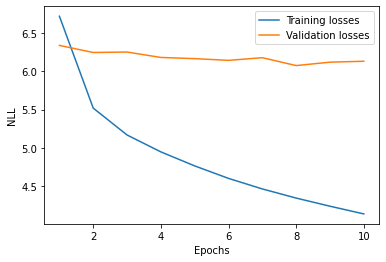

In [205]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [206]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | in regular area initially Guitar military 4 southern felt miles
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | km area ' north military cm southern characters miles mm
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | of , given San Street others h miles mm change
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | ( would Some Street Forest guns ? said taken recorded
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | . Some Street 18 possible feet said born named be
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | of such $ taken Street Wor

In [1]:
# runid=1669399860
# epoch=10
# !cp /content/experiments/{runid}/predictions-test-{epoch}.npy predictions.npy
# !cp /content/experiments/{runid}/generated-{epoch}.txt generated.txt
# !cp /content/experiments/{runid}/generated_logits-test-{epoch}.npy generated_logits.npy
# !cp "/content/drive/MyDrive/Colab Notebooks/HW4P1.ipynb" training.ipynb
# !tar -cvf handin.tar training.ipynb predictions.npy generated.txt generated_logits.npy
# !rm -f training.ipynb predictions.npy

cp: cannot stat '/content/experiments/1669399860/predictions-test-10.npy': No such file or directory
cp: cannot stat '/content/experiments/1669399860/generated-10.txt': No such file or directory
cp: cannot stat '/content/experiments/1669399860/generated_logits-test-10.npy': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/HW4P1.ipynb': No such file or directory
tar: training.ipynb: Cannot stat: No such file or directory
tar: predictions.npy: Cannot stat: No such file or directory
tar: generated.txt: Cannot stat: No such file or directory
tar: generated_logits.npy: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [208]:
# from google.colab import files
# files.download('handin.tar') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>